**Before you start**<br>
Change runtime type to GPU <br>
Runtime > Change runtime type > GPU > Save

In [ ]:
# !gdown --id 1gduPsoM2TmwbwwaOru083aMg_HOA-9V6
# !unzip -qq /content/202003231356_NPP_VII_ALI_43539_721.zip

In [ ]:
# !unzip -qq /content/202003231356_NPP_VII_ALI_43539_721.zip

In [2]:
# install fastai
# !pip install -Uqq fastbook
from fastai.vision.all import *
%matplotlib inline  


In [3]:
# Point script at data
# path = Path('/content/training data')
path = Path('/data/cloud detection/training data')
path

Path('/data/cloud detection/training data')

In [4]:
# define model name
model_name = 'cloud_model'

In [5]:
# make sure things look correct
path.ls()

(#4) [Path('/data/cloud detection/training data/cloud'),Path('/data/cloud detection/training data/no cloud'),Path('/data/cloud detection/training data/classes.csv'),Path('/data/cloud detection/training data/models')]

In [6]:
# set model settings
batch_size = 10
img_size = 100

In [7]:
# define image transforms
item_tfms = [Resize(img_size)]
batch_tfms = [Normalize.from_stats(*imagenet_stats),
            *aug_transforms(size=img_size, flip_vert=True,max_rotate=90.0,max_lighting=0.1,
                            min_zoom=0.8, max_zoom=1.3, max_warp=0,                             
                            )]


In [8]:
# load data
data = ImageDataLoaders.from_folder(path, train=".", valid_pct=0.2,splitter=RandomSplitter(seed=42),
                                    bs=batch_size,
                                    item_tfms=item_tfms,
                                    batch_tfms=batch_tfms
                                   )


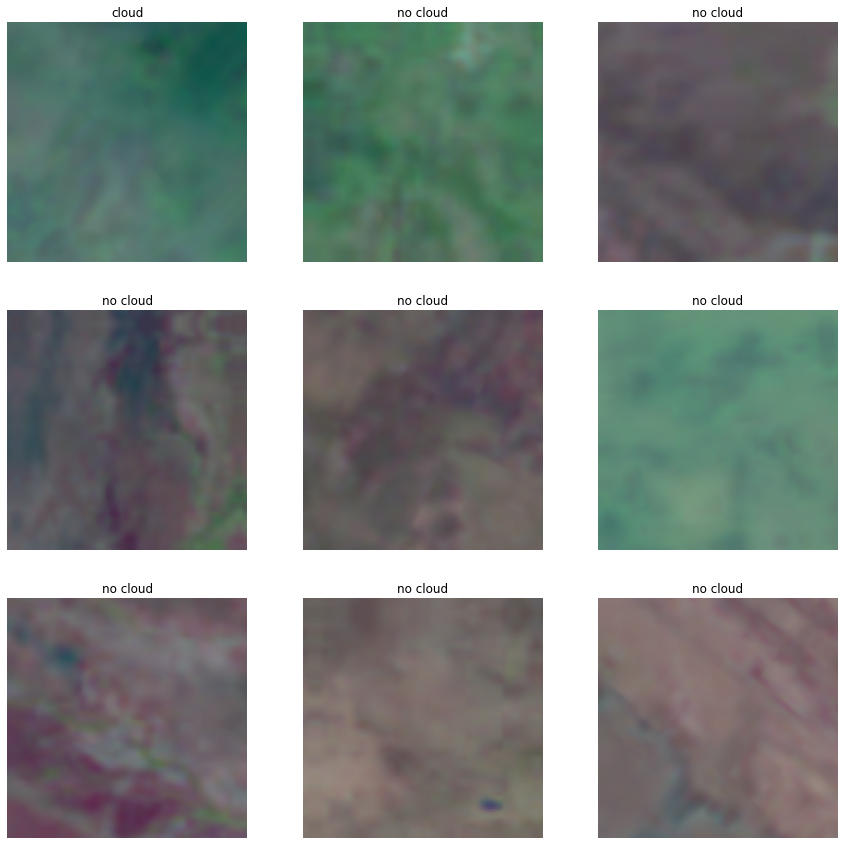

In [9]:
# check data
data.show_batch(max_n = 9, figsize = (15,15))

In [10]:
# save classes to txt file
np.savetxt(path/'classes.csv', np.array(data.vocab), fmt='%s')

In [11]:
# make model
learn = cnn_learner(data, resnet18, metrics=error_rate)

/home/nick/anaconda3/envs/fa/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [12]:
# learn.fine_tune?

Better model found at epoch 0 with valid_loss value: 0.2032802700996399.


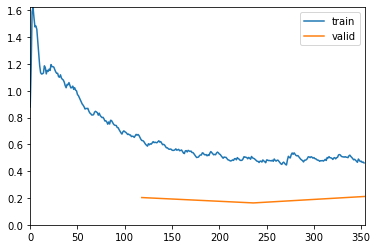

Better model found at epoch 1 with valid_loss value: 0.1631946712732315.


Better model found at epoch 0 with valid_loss value: 0.13274416327476501.


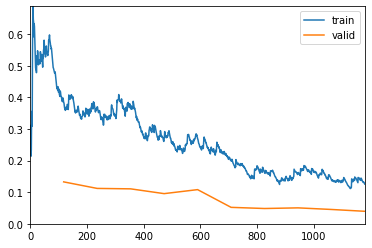

Better model found at epoch 1 with valid_loss value: 0.11204950511455536.
Better model found at epoch 2 with valid_loss value: 0.1106797456741333.
Better model found at epoch 3 with valid_loss value: 0.09552574902772903.
Better model found at epoch 5 with valid_loss value: 0.052091386169195175.
Better model found at epoch 6 with valid_loss value: 0.04842629283666611.
Better model found at epoch 8 with valid_loss value: 0.04538594186306.
Better model found at epoch 9 with valid_loss value: 0.03956790268421173.


In [13]:
# train model
learn.fine_tune(10,freeze_epochs=3,cbs = [ShowGraphCallback(),
                         SaveModelCallback(monitor='valid_loss',with_opt=True, fname=model_name)])


In [14]:
learn.load(model_name)

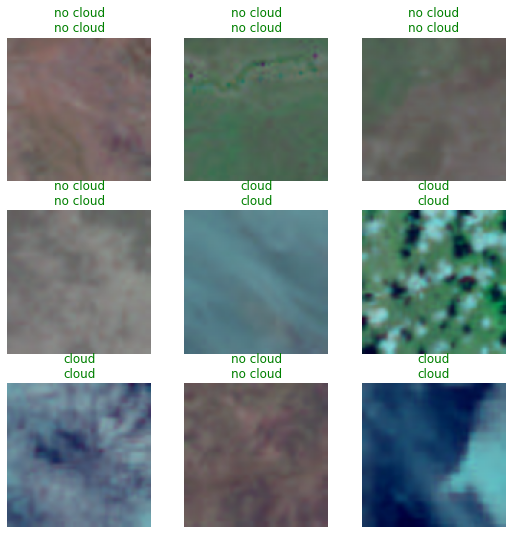

In [15]:
# check the outputs
learn.show_results()

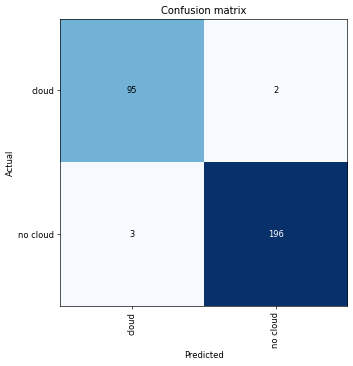

In [16]:
# check confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [17]:
# export model to disk
learn.export('models/'+model_name+'.pkl')

# Infernce

In [ ]:
# install some GIS tools
# !pip install geopandas
# !pip install rasterio

In [23]:
import os
import rasterio
from tqdm.auto import tqdm
from multiprocess import Pool,cpu_count
from pathlib import Path

In [24]:
# !gdown --id 1gduPsoM2TmwbwwaOru083aMg_HOA-9V6
# !unzip -qq /content/202003231356_NPP_VII_ALI_43539_721.zip

In [25]:
raster_path = '/data/cloud detection/202005051350_NPP_VII_ALI_44149_721_clip.tif'
os.path.isfile(raster_path)

True

In [26]:
output_folder = os.path.splitext(raster_path)[0]+'_chunks'
Path(output_folder).mkdir(parents=True, exist_ok=True)
output_folder

'/data/cloud detection/202005051350_NPP_VII_ALI_44149_721_clip_chunks'

In [27]:
size = [50,50] #[x,y]
output_compression = 'JPEG'#'lZW'
output_format = 'GTiff'

In [28]:
with rasterio.open(raster_path) as open_raster:
    input_meta = open_raster.meta
input_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 236.0,
 'width': 2180,
 'height': 1606,
 'count': 3,
 'crs': CRS.from_epsg(3857),
 'transform': Affine(455.65406536697196, 0.0, 12624609.2728,
        0.0, -455.6808777708591, -2773780.642)}

In [29]:
# make a list of chunks by looping over raster height and width
tiles = []
left = 0
tile_count = 0
while left < input_meta['width']:
    top=0
    while top < input_meta['height']:
        tile_count += 1
        name = 'part_'+str(tile_count)+'_'+os.path.basename(raster_path)
        export_path = os.path.join(output_folder,name)
        
        tiles.append([left,top,export_path])
        top += size[1]
    left += size[0]
print(len(tiles))
tiles[0]

1452


[0,
 0,
 '/data/cloud detection/202005051350_NPP_VII_ALI_44149_721_clip_chunks/part_1_202005051350_NPP_VII_ALI_44149_721_clip.tif']

In [30]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

In [31]:
def tile_cutter(chunks):
    
    with rasterio.open(raster_path) as src:
        for chunk in chunks:
#             print(chunk)
            win = rasterio.windows.Window(chunk[0], chunk[1], size[0], size[1])
            win_data = src.read(window=win)
            win_transform = src.window_transform(win)
            meta = src.meta
            meta['compress'] = output_compression
            meta['driver'] = output_format
            meta['transform'] = win_transform
            meta['width'] = win_data.shape[2]
            meta['height'] = win_data.shape[1]
            with rasterio.open(chunk[2], 'w', **meta) as dst:
                dst.write(win_data)
            win_data = None

In [32]:
cores = cpu_count()
cores

8

In [33]:
with Pool(cores) as p:
    list(tqdm(p.imap(tile_cutter, list(split(tiles,cores))), total=len(list(split(tiles,cores)))))

  0%|          | 0/8 [00:00<?, ?it/s]

In [34]:
# import more tools
# GIS
import geopandas as gpd
import rasterio
from shapely.geometry import box
# system
from multiprocessing import Pool
from tqdm.auto import tqdm

In [35]:
# !gdown --id 1uzKfIzm0su1oVzDxkqIdZXU1JMLlp2rf

In [36]:
# !unzip -qq /content/Inference_data.zip

In [37]:
# point this at the tiled data
input_raster_path = output_folder
# this is the output file path
export_vector_path = input_raster_path+'.gpkg'
export_vector_path

'/data/cloud detection/202005051350_NPP_VII_ALI_44149_721_clip_chunks.gpkg'

In [38]:
# read calsses from text file
classes = np.loadtxt(path/'classes.csv',delimiter='\n', dtype=str)
classes

array(['cloud', 'no cloud'], dtype='<U8')

In [39]:
# find all files and grab the CRS of one of them
input_rasters = []

for root, dirs, files in os.walk(input_raster_path):
    for file in files:
        if file.endswith('.tif'):
            input_rasters.append(os.path.join(root, file))

dataset = rasterio.open(input_rasters[0])
crs = dataset.crs
            
print('File count',len(input_rasters))
print('CRS',crs)

File count 1452
CRS EPSG:3857


In [40]:
# load model setup up data and pushes to GPU
learn_inf = load_learner(path/str('models/'+model_name+'.pkl'))
learn_inf.dls.cuda()
dl = learn_inf.dls.test_dl(input_rasters,device='cuda',bs=batch_size)

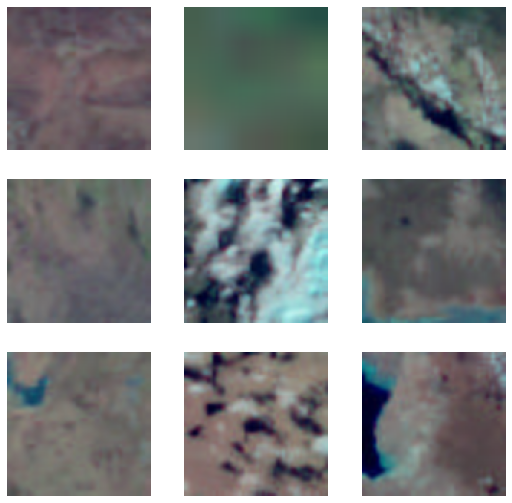

In [41]:
# display a batch
dl.show_batch()

In [42]:
# run model
pred_scores,none,pred_class_int = learn_inf.get_preds(dl=dl,with_decoded=True)

In [43]:
# pred_class_int

In [44]:
# use rasterio to open every raster and extract its extent
def get_bounds(raster):
    try:
        dataset = rasterio.open(raster)
        bounds = dataset.bounds
        geom = box(*bounds)
    except:
        print(raster)
    return geom

In [45]:
colors = ['#0000FF','#FF0000']

In [46]:
len(input_rasters)

1452

In [47]:
# loop over data and save into list as dict
pred_dict_list = []
for pred_int,file_path,pred_score in tqdm(zip(pred_class_int,input_rasters,pred_scores.cpu().detach().numpy()),total=len(input_rasters)):
#     build dict for each image
    pred_dict = {'path':file_path,
                'pred_class':classes[pred_int],
                 'color' : colors[pred_int],
                 'geometry':get_bounds(file_path)
                 }
#     add n number of class preds
    for class_name in classes:
        pred_index = list(classes).index(class_name)
        pred_dict[class_name] = pred_score[pred_index]

        
    pred_dict_list.append(pred_dict)

  0%|          | 0/1452 [00:00<?, ?it/s]

In [48]:
# build list of dicts into dataframe
preds_gdf = gpd.GeoDataFrame(pred_dict_list,crs=crs,geometry='geometry')

<AxesSubplot:>

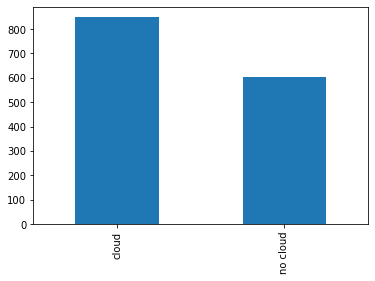

In [49]:
# plot distrobution
fig, ax = plt.subplots()
preds_gdf['pred_class'].value_counts().plot(ax=ax, kind='bar')

In [50]:
# export vector file
preds_gdf.to_file(export_vector_path, driver="GPKG")

In [51]:
# !pip install folium

In [52]:
import folium

In [53]:
preds_gdf_json = preds_gdf.to_crs(epsg='4326').to_json()

In [54]:
def style(feature):
        return {
            'fillColor': feature['properties']['color'],
            'color': feature['properties']['color'],
            'weight': 1
        }

In [55]:
mapa = folium.Map([-34,117.5],
                  zoom_start=9,
                  tiles='cartodbpositron')

pred_polys = folium.features.GeoJson(preds_gdf_json,style_function=style)

mapa.add_child(pred_polys)
mapa

In [56]:
# download full image
# !gdown --id 13nA0BA3N0B43ItR-aqXaFzplxnliZNMa

In [93]:
map_image = '/data/cloud detection/202005051350_NPP_VII_ALI_44149_721_clip_warp.tif'

In [95]:
# reasample image
from PIL import Image

im = Image.open(map_image)
# Image.MAX_IMAGE_PIXELS = None

rgb_im = im.convert('RGB')

# newsize = (2180, 1605)

# rgb_im = rgb_im.resize(newsize)

resample_img_name = 'resample.jpg'

rgb_im.save(resample_img_name)

In [96]:
bounds = rasterio.open(map_image).bounds
type(bounds)

rasterio.coords.BoundingBox

In [97]:
[[bounds.top,bounds.left],[bounds.bottom,bounds.right]]

[[-24.167078773, 113.408794658], [-30.015980333, 122.331992702]]

In [98]:
map = folium.Map([-34,117.5],
                  zoom_start=9,
                  tiles='cartodbpositron')

folium.raster_layers.ImageOverlay(
    image=resample_img_name,
    bounds=[[bounds.bottom,bounds.left],[bounds.top,bounds.right]],
).add_to(map)


pred_polys = folium.features.GeoJson(preds_gdf_json,style_function=style)

map.add_child(pred_polys)
map

In [82]:
[[bounds.bottom,bounds.left],[bounds.top,bounds.right]]

[[-30.015980333, 113.408794658], [-24.167078773, 122.331992702]]